In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms

In [40]:
BATCH_SIZE = 20
VALID_SPLIT = 0.2
SEED = 42

LEARNING_RATE = 0.001
N_EPOCHS = 5


In [28]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


#### Load data

In [29]:
transf = transforms.ToTensor()

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                     transforms.ToTensor()])


train_folder = datasets.ImageFolder(root="../dataset/train/", 
                                    transform=transf)
test_folder = datasets.ImageFolder(root="../dataset/test/", 
                                   transform=transf)
# print out some data stats
print(f"{len(train_folder)} train images")
print(f"{len(test_folder)} test images")

10000 train images
3000 test images


In [30]:
classes = test_folder.classes
print(classes)

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [31]:
n_train = len(train_folder)
indices = list(range(n_train))
np.random.seed(SEED)
np.random.shuffle(indices)
split = int(np.floor(VALID_SPLIT * n_train))
train_indices, valid_indices = indices[split:], indices[:split]

In [32]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [33]:
train_loader = torch.utils.data.DataLoader(train_folder, 
                                           batch_size=BATCH_SIZE, 
                                           sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(train_folder, 
                                           batch_size=BATCH_SIZE, 
                                           sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(test_folder, 
                                          batch_size=BATCH_SIZE)

#### Define the model by modifying VGG16

---

To define a model for training we'll follow these steps:
1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor 
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

1) Load in a pre-trained VGG16 model

In [34]:
vgg16 = models.vgg16(pretrained=True)

In [35]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

2. "Freeze" all the parameters, so the net acts as a fixed feature extractor 

In [36]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False
    
# Freeze training for all "classifier" layers
for param in vgg16.classifier.parameters():
    param.requires_grad = False


3) Remove the last layer
4) Replace the last layer with a linear classifier of our own

In [37]:
## new layers automatically have requires_grad = True

n_inputs = vgg16.classifier[-1].in_features
last_layer = nn.Linear(in_features=n_inputs,
                       out_features=len(classes))

vgg16.classifier[-1] = last_layer

# after completing your model, if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

In [38]:
for cl in vgg16.classifier:
    print(cl)
    for p in cl.parameters():
        print(p.requires_grad)

Linear(in_features=25088, out_features=4096, bias=True)
False
False
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=4096, out_features=4096, bias=True)
False
False
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=4096, out_features=10, bias=True)
True
True


#### Training

In [42]:
import torch.optim as optim

# loss function: categorical cross-entropy
criterion = nn.CrossEntropyLoss()

# optimizer: stochastic gradient descent
optimizer = optim.SGD(vgg16.classifier[-1].parameters(), lr=LEARNING_RATE)

In [46]:
# number of epochs to train the model
n_epochs = 2

## TODO complete epoch and training batch loops
## These loops should update the classifier-weights of this model
## And track (and print out) the training loss over time


vgg16.train()  # put model in training mode

losses = []

for epoch in range(n_epochs):

    train_loss = 0.0
    print(f"\nepoch {epoch+1}")
    ###################
    # train the model #
    ###################
    for i, (data, target) in enumerate(train_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()  
    
        optimizer.zero_grad()  # clear all gradients
        output = vgg16(data)  # forward pass: predict
        loss = criterion(output, target)
        loss.backward()  # backward pass: compute gradient of the loss
        optimizer.step()  # update parameters
        
        batch_loss = loss.item() * data.size(0)
        if (i+1) % 10 == 0:
            print(f"batch: {i+1}\tTraining loss per example: {batch_loss/BATCH_SIZE}")
        train_loss += batch_loss
        
    # average loss per epoch
    train_loss = train_loss / len(train_loader.dataset)
    losses.append(train_loss)
    print(f"Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f}")


epoch 1
batch: 10	Training loss per example: 2.0094785690307617
batch: 20	Training loss per example: 1.6887658834457397
batch: 30	Training loss per example: 1.3410053253173828
batch: 40	Training loss per example: 1.5656121969223022
batch: 50	Training loss per example: 1.7686693668365479
batch: 60	Training loss per example: 1.5010311603546143
batch: 70	Training loss per example: 1.6623127460479736
batch: 80	Training loss per example: 1.3975480794906616
batch: 90	Training loss per example: 1.3384262323379517
batch: 100	Training loss per example: 1.3060837984085083
batch: 110	Training loss per example: 1.2760083675384521
batch: 120	Training loss per example: 1.3861721754074097
batch: 130	Training loss per example: 1.3800084590911865
batch: 140	Training loss per example: 1.0914385318756104
batch: 150	Training loss per example: 1.0711723566055298
batch: 160	Training loss per example: 1.1634328365325928
batch: 170	Training loss per example: 1.0366274118423462
batch: 180	Training loss per ex

#### Testing

In [50]:
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

vgg16.eval() # eval mode

# iterate over test data
for i, (data, target) in enumerate(test_loader):
    
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    
    if (i+1) % 10 == 0:
        print(f"test batch {i+1}/{len(test_loader)}, loss {loss.item()}")

    # update  test loss 
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(BATCH_SIZE):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print(f"Test Loss: {test_loss:.6f}\n")

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

test batch 10/150, loss 0.5491948127746582
test batch 20/150, loss 0.314028799533844
test batch 30/150, loss 0.5449975728988647
test batch 40/150, loss 0.3005339205265045
test batch 50/150, loss 1.1292916536331177
test batch 60/150, loss 0.7274377942085266
test batch 70/150, loss 0.3347337245941162
test batch 80/150, loss 1.1381046772003174
test batch 90/150, loss 0.7834134697914124
test batch 100/150, loss 0.9607161283493042
test batch 110/150, loss 0.7796818614006042
test batch 120/150, loss 0.8343912959098816
test batch 130/150, loss 0.4504527151584625
test batch 140/150, loss 0.5344475507736206
test batch 150/150, loss 0.692173421382904
Test Loss: 0.715425

Test Accuracy of airplane: 78% (236/300)
Test Accuracy of  bird: 76% (229/300)
Test Accuracy of   car: 90% (270/300)
Test Accuracy of   cat: 69% (207/300)
Test Accuracy of  deer: 76% (229/300)
Test Accuracy of   dog: 56% (170/300)
Test Accuracy of horse: 77% (232/300)
Test Accuracy of monkey: 69% (209/300)
Test Accuracy of  ship

#### Visualize Sample Test Results

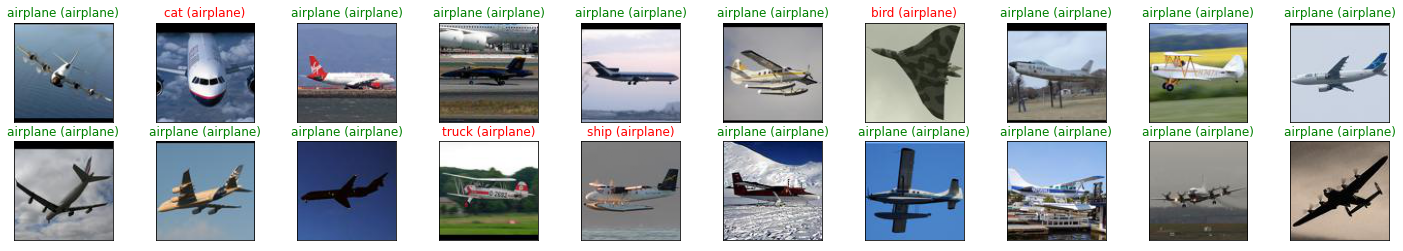

In [53]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in range(BATCH_SIZE):
    ax = fig.add_subplot(2, int(BATCH_SIZE/2), idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx].permute(1, 2, 0))  # CHW -> HWC
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

#### Transfer Learning (first steps with VGG16) conclusion

Model : VGG16 pretrained on ImageNet
    
* .feature layers (conv, pool): weights frozen, acting as feature extractor
* .classifier layers (fully-connected linear): learned from STL-10
    * all but the last FC layer: initialized from pre-trained VGG16
    * the last FC layer: old 4096x1000 is replaced with the new 4096x10 one, random weights init.
 
Total accuracy of 77%, way better than previous tests with a simple custom CNN trained from scratch (59%) or an MLP (37%).

We take benefit from the pre-trained VGG16 model, for several reasons:
* A well-designed CNN with robust architecture, widely used around the world.
* Reusing conv+pool layers with weights already learnt from ImageNet dataset. Our STL dataset has objects with more-or-less the same nature that ImageNet objects, not like if it was something completely different like
    * microscope images;
    * satellite images;
    * medical images, etc.
    

Next steps to improve the accuracy:
1) Train for more epochs (currently was trained for only 2 epochs, just as a test).
2) Try freezing all FC layers and only learn last linear layer's parameters. Compare what is the best approach here:
    * using all layers (except the last one) as a feature extractor;
    * use only .features (conv+pool) layers as feature extractor, learn params for all linear layers.
3) Try different CNN architectures, other than VGG16.
4) Use **semi-supervised learning** approach, making use of *unlabelled* data.
5) Pre-training feature extraction layer on STL-10 rather than using feature extractor trained on ImageNet.

